In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn import datasets
from skimage import io, color, transform
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./dataset/SB-FishDisease.csv")

In [3]:
df['target'].value_counts()

target
disease    268
healthy    155
Name: count, dtype: int64

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['sickness'], random_state=42)

print("Träningsuppsättning:")
print(train_df['sickness'].value_counts())

print("\nTestuppsättning:")
print(test_df['sickness'].value_counts())

Träningsuppsättning:
sickness
healthy_fish                         113
bacterial_gill disease                43
fungal_diseases_saprolegniasis        37
bacterial_diseases _aeromoniasis      37
bacterial_red disease                 36
viral_diseases_white_tail_disease     33
parasitic_diseases                    28
healthy_gills                         11
Name: count, dtype: int64

Testuppsättning:
sickness
healthy_fish                         28
bacterial_gill disease               11
bacterial_diseases _aeromoniasis     10
fungal_diseases_saprolegniasis        9
bacterial_red disease                 9
viral_diseases_white_tail_disease     8
parasitic_diseases                    7
healthy_gills                         3
Name: count, dtype: int64


In [5]:
def load_images(file_paths, target_size=(64, 64)):
    images = []
    for path in file_paths:
        img = io.imread(path)
        img_resized = transform.resize(img, target_size)
        images.append(img_resized)

    sizes = images[0].shape
    images_resized = [transform.resize(img, sizes) for img in images]

    return np.stack(images_resized)

In [6]:
df = pd.read_csv("./dataset/splitted_and_augmented_data/augmented_data.csv")

In [7]:
df['target'].value_counts()

target
disease    1124
healthy     651
Name: count, dtype: int64

In [8]:
train_df = df[df['data'] == 'train']
test_df = df[df['data'] == 'test']

In [6]:
target_size = (64, 64)
X_train = load_images(train_df['path'], target_size=target_size)
X_test = load_images(test_df['path'], target_size=target_size)
y_train = train_df['target']
y_test = test_df['target']

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model = make_pipeline(StandardScaler(), PCA(n_components=100), SVC(kernel='linear', C=1))
model.fit(X_train_flat, y_train)

y_pred = model.predict(X_test_flat)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6588235294117647


In [7]:
def prepare_image(file_path, target_size=(64, 64)):
    img = io.imread(file_path)
    img_resized = transform.resize(img, target_size)
    img_flat = img_resized.flatten()
    return img_flat

In [8]:
def random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print("Inga bilder hittades i mappen.")
        return None

    random_image = random.choice(image_files)

    img_path = os.path.join(folder_path, random_image)

    return img_path

Förutsägelse: ['healthy']


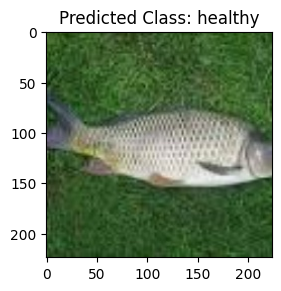

In [9]:
folder_path = './dataset/YOLOstacked/images/'
test_image_path = random_image(folder_path)
test_image = prepare_image(test_image_path)
prediction = model.predict([test_image])

print(f"Förutsägelse: {prediction}")

predicted_class = prediction[0]
original_image = io.imread(test_image_path)

plt.subplot(1, 2, 2)
plt.imshow(original_image)
plt.title(f'Predicted Class: {predicted_class}')

plt.show()

In [10]:
test_folder_path = './dataset/test_img/Healthy_fishies/'

# Dictionary för att lagra noggrannheter per undermapp
accuracy_per_class = {}

# Loopa igenom varje undermapp i testmappen
for subdir, dirs, files in os.walk(test_folder_path):
    # Ignorera rotmappen
    if subdir == test_folder_path:
        continue

    # Lista för att lagra sanna klasser och förutsagda klasser för den aktuella undermappen
    true_labels = []
    predicted_labels = []

    for file in files:
        # Skapa den fullständiga sökvägen till varje bild
        img_path = os.path.join(subdir, file)
        test_image = prepare_image(img_path)

        # Gör prediktion med modellen
        prediction = model.predict([test_image])

        # Bestäm sann klass från undermappens namn
        true_class = os.path.basename(subdir)

        predicted_class = prediction[0]

        true_labels.append('healthy')
        predicted_labels.append(predicted_class)

    # Beräkna noggrannhet för den aktuella undermappen
    accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
    accuracy_per_class[true_class] = accuracy

In [24]:
# Skriv ut noggrannhet per undermapp
for class_name, accuracy in accuracy_per_class.items():
    print(f"Noggrannhet för {class_name}: {accuracy * 100:.2f}%")

Noggrannhet för Black Sea Sprat: 58.33%
Noggrannhet för Gilt-Head Bream: 44.23%
Noggrannhet för Hourse Mackerel: 50.00%
Noggrannhet för Red Mullet: 36.36%
Noggrannhet för Red Sea Bream: 41.30%
Noggrannhet för Sea Bass: 42.11%
Noggrannhet för Striped Red Mullet: 55.00%
